<a href="https://colab.research.google.com/github/Pisarenkova/KT_2025/blob/main/%22fenics_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [ ]:
!apt-get install -y software-properties-common
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update
!apt-get install -y fenics

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Repository: 'deb https://ppa.launchpadcontent.net/fenics-packages/fenics/ubuntu/ jammy main'
Description:
This PPA provides packages for the FEniCS project (https://fenicsproject.org).
More info: https://launchpad.net/~fenics-packages/+archive/ubuntu/fenics
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-jammy.list
Adding key to /etc/apt/trusted.gpg.d/fenics-packages-ubuntu-fenics.gpg with fingerprint 6C1DA1C0EC4B649179C1C7437C3297BD11D01687
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get

In [ ]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2025-03-22 08:36:27--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.110.153, 185.199.109.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-03-22 08:36:28 (50.9 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f33a7ab/releases/pybi

Общее решение

In [ ]:
from fenics import *
#from petsc4py import PETSc

import numpy as np
import matplotlib.pyplot as plt

# Точное решение
def u(x, y):
    return np.sin(k * x) * np.cos(l * y)

def create_mesh(h):
    #Прямоугольник
    p0 = Point(0.0, 0.0)
    p1 = Point(np.pi, np.pi)

    # Шаг h
    return RectangleMesh(p0, p1, int(np.pi/h), int(np.pi/h))

def solve_pde(f_exp, u_d, h):
    mesh = create_mesh(h)
    V = FunctionSpace(mesh, 'P', 1)

    # Граничные условия
    u_D = Expression(u_d, degree=2)
    bc = DirichletBC(V, u_D, 'on_boundary')

    # Вариационная форма
    u = TrialFunction(V)
    v = TestFunction(V)
    f_expr = Expression(f_exp, degree=2)
    #print(f_expr)
    a = inner(nabla_grad(u), nabla_grad(v)) * dx
    L = f_expr * v * dx

    # Решение
    u = Function(V)
    solve(a == L, u, bc)

    return mesh, u

Визуализация решения

In [186]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.gridspec as gridspec

u_d = ['sin(x[0])*cos(x[1])', 'sin(5*x[0])*cos(5*x[1])','sin(2*x[0])*cos(10*x[1])']
f_exp = ['sin(x[0])*cos(x[1])', '50*sin(5*x[0])*cos(5*x[1])','104*sin(2*x[0])*cos(10*x[1])']

def visualize_solution(k,l,h,i):

    x = np.linspace(0, np.pi, 100)
    y = np.linspace(0, np.pi, 100)
    X, Y = np.meshgrid(x, y)
    y_exact = np.sin(k*X) * np.cos(l*Y)

    mesh, u_solution = solve_pde(f_exp[i], u_d[i], h)
    #print(u_solution.vector())

    # Графики
    h_min, h_max, v_min, v_max = 0, np.pi, 0, np.pi

    fig = plt.figure(figsize=(9, 8))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 0.04], wspace=0.5, hspace=0.3)

    #exact_sol = interpolate(Expression('sin(x[0])*cos(x[1])', degree=2), u_solution.function_space())

    titles = ["Точное решение", "Абсолютная разность"]
    data = [y_exact.reshape(100, 100, order='F')]

    def create_subplot(ax, data, title):
        c = ax.imshow(data, extent=(h_min, h_max, v_min, v_max), origin='lower', cmap='RdBu_r')
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('y', fontsize=12)
        ax.set_xticks([0, np.pi/2, np.pi])
        ax.set_xticklabels(['$0$', '$\pi/2$', '$\pi$'])
        ax.set_yticks([0, np.pi/2, np.pi])
        ax.set_yticklabels(['$0$', '$\pi/2$', '$\pi$'])



    c1 = create_subplot(fig.add_subplot(gs[0, 0]), data[0], titles[0])
    plot(u_solution,fig.add_subplot(gs[0,1]), extent=(h_min, h_max, v_min, v_max), origin='lower', cmap='RdBu_r')
    plt.title("Решение FEniCS", fontsize=12)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)
    plt.xticks([0, np.pi/2, np.pi], ['$0$', '$\pi/2$', '$\pi$'])
    plt.yticks([0, np.pi/2, np.pi], ['$0$', '$\pi/2$', '$\pi$'])

    norm = colors.Normalize(vmin=-1, vmax=1)
    cbar = fig.colorbar(c1, cax=fig.add_subplot(gs[0, 2]), norm=norm, cmap='RdBu_r')
    cbar.set_ticks(np.linspace(np.min(data[0]), np.max(data[0]), 9).round(2))

    # M=np.linspace(0, np.pi, 49)

    # plt.plot(M,np.abs(u_solution.vector().get_local() - exact_sol.vector().get_local()),fig.add_subplot(gs[0,3]))

    # def add_colorbar(c, ax, data):
    #     norm = plt.Normalize(np.min(data), np.max(data))
    #     cbar = fig.colorbar(c, cax=ax, norm=norm)
    #     cbar.set_ticks(np.linspace(np.min(data), np.max(data), 9).round(3))

    #add_colorbar(c1, fig.add_subplot(gs[0, 4]), data[2])

    plt.show()

Анализ зависимости ошибок от h

In [171]:
def analyze_errors(i):
        h_values=[1, 0.5, 0.25, 0.125, 0.05]

        errors_L2 = []
        errors_C = []
        errors_H1 = []

        for h in h_values:
              mesh, numerical_solution = solve_pde(f_exp[i],u_d[i],h)

              # Вычисление ошибок
              exact_sol = interpolate(Expression(u_d[i], degree=2), numerical_solution.function_space())
              error_L2 = errornorm(exact_sol, numerical_solution, 'L2')
              error_C = np.max(np.abs(numerical_solution.vector().get_local() - exact_sol.vector().get_local()))
              error_H1 = errornorm(exact_sol, numerical_solution, 'H1')

              errors_L2.append(error_L2)
              errors_C.append(error_C)
              errors_H1.append(error_H1)

        #vmin=np.min(np.min(np.min(error_C),np.min(error_H1)),np.min(error_L2))
        #vmax=np.max(np.max(np.max(error_C),np.max(error_H1)),np.max(error_L2))

        plt.figure()
        plt.loglog(h_values, errors_L2, label='L2 Error', marker='o')
        plt.loglog(h_values, errors_C, label='C Error', marker='x')
        plt.loglog(h_values, errors_H1, label='H1 Error', marker='s')
        plt.xticks([0.05, 0.125, 0.25, 0.5, 1], ['$0.05$', '$0.125$', '$0.25$', '$0.5$', '$1$'])
        plt.xlabel('Шаг h')
        plt.ylabel('Ошибка')
        plt.title('Анализ ошибок')
        plt.legend()
        plt.grid()
        plt.show()

$k=1$, $\;l=1$

$u=\sin{x}⋅\cos{y}$


Шаг h =  1


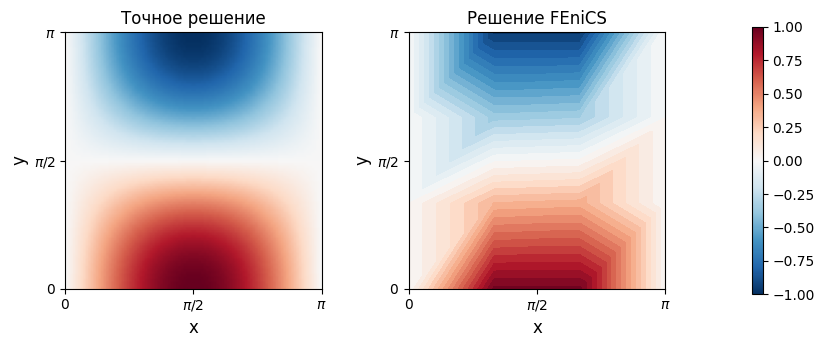

Шаг h =  0.5


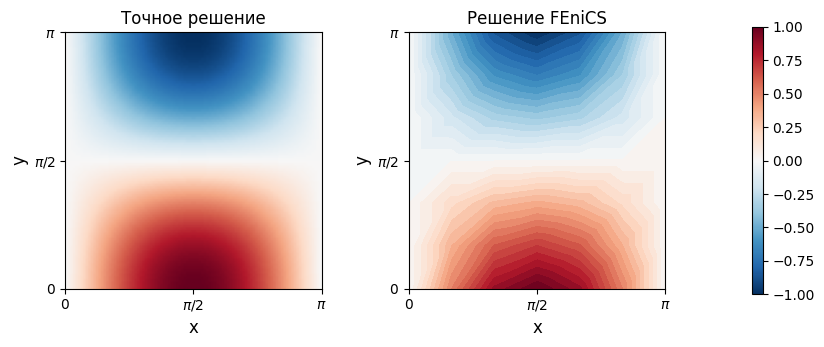

Шаг h =  0.25


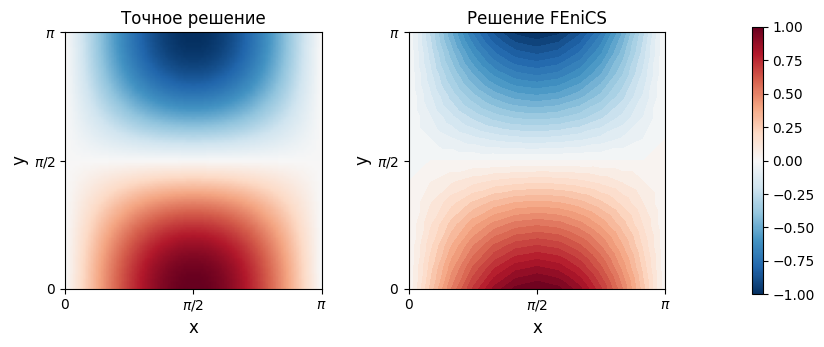

Шаг h =  0.125


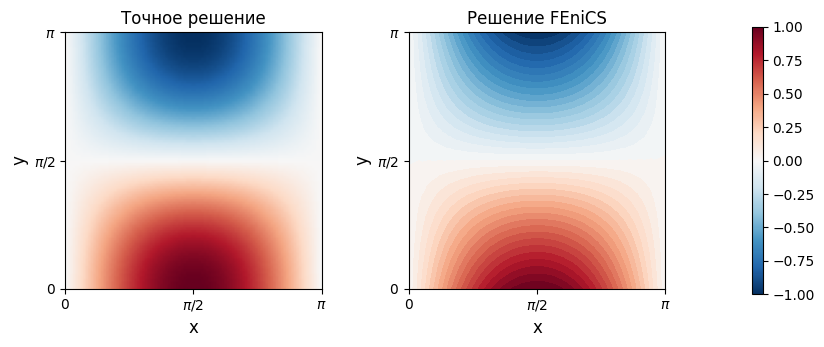

Шаг h =  0.05


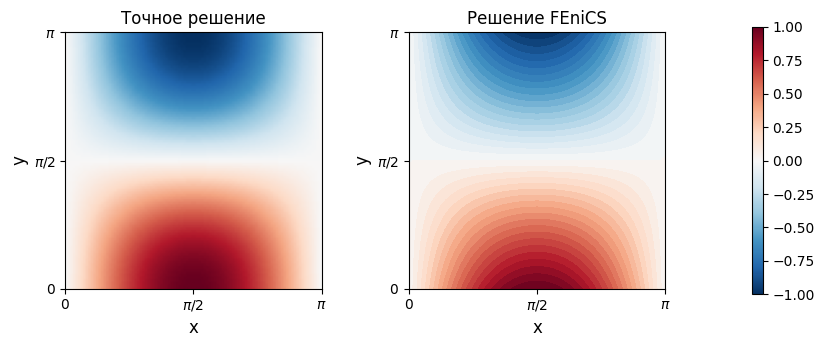

In [187]:
k = 1
l = 1
i = 0
h=[1, 0.5, 0.25, 0.125, 0.05]
for h_values in h:
  #mesh, u_solution = solve_pde(f_exp[i], u_d[i], h)

  print(f"Шаг h =  {h_values}")
  visualize_solution(k,l,h_values,i)

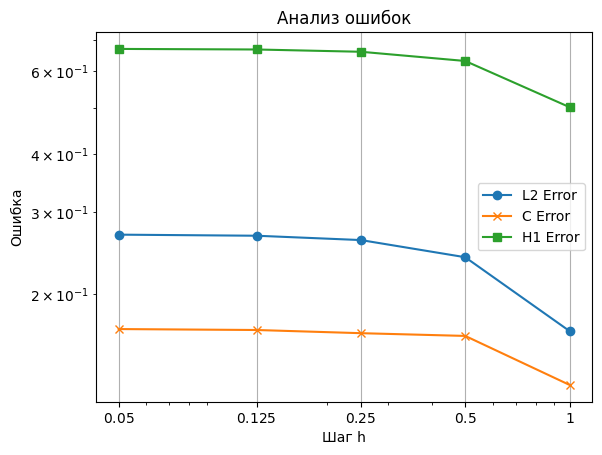

In [173]:
analyze_errors(0)

$k=5$, $\,l=5$

$u=\sin{5x}\cos{5y}$

Шаг h =  1


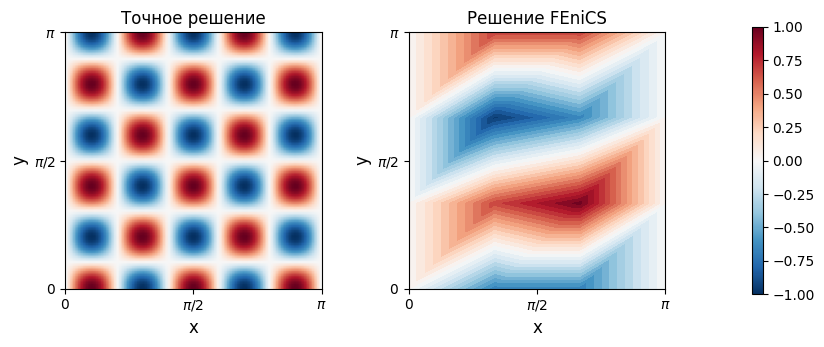

Шаг h =  0.5


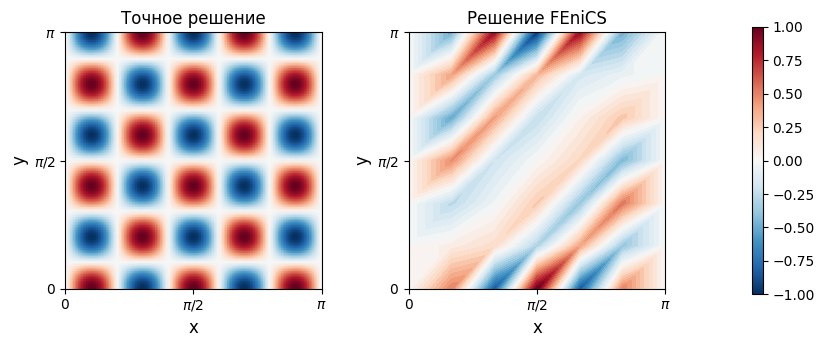

Шаг h =  0.25


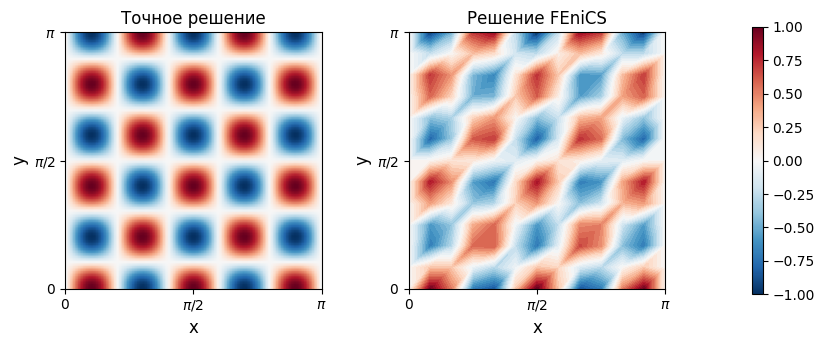

Шаг h =  0.125


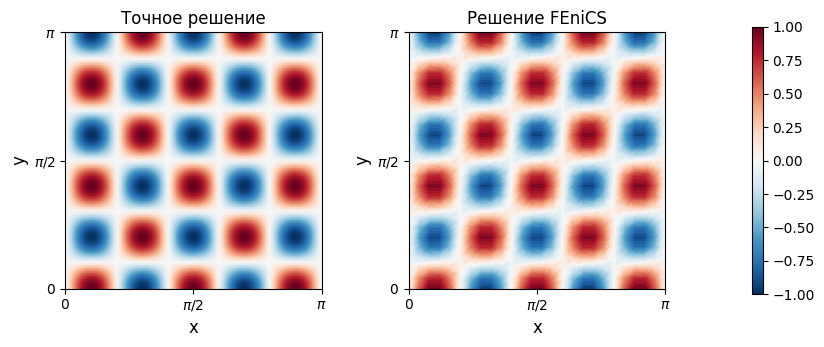

Шаг h =  0.05


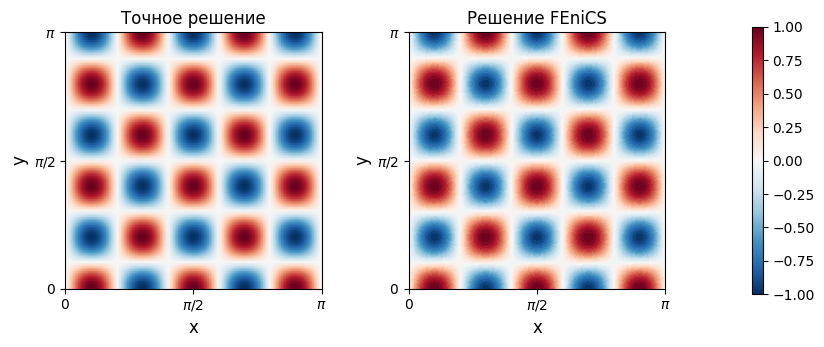

In [188]:
k = 5
l = 5
i = 1
h=[1, 0.5, 0.25, 0.125, 0.05]
for h_values in h:
  #mesh, u_solution = solve_pde(f_exp[i], u_d[i], h)

  print(f"Шаг h =  {h_values}")
  visualize_solution(k,l,h_values,i)

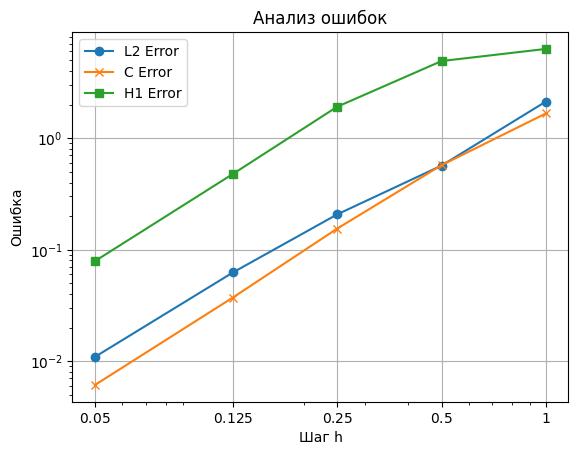

In [174]:
analyze_errors(1)

$k=2$, $\,l=10$

$u=\sin{2x}\cos{10y}$

Шаг h =  1


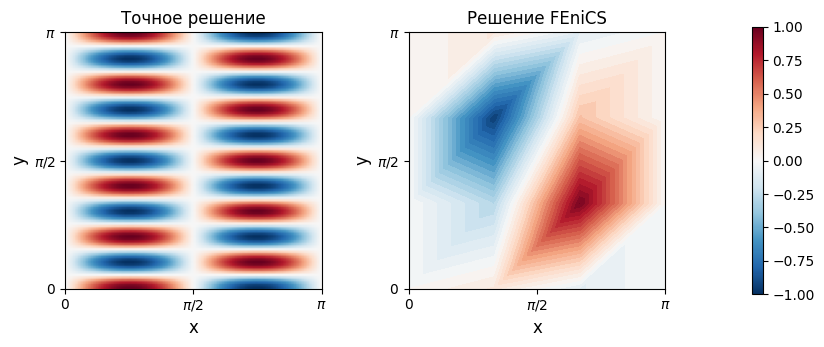

Шаг h =  0.5


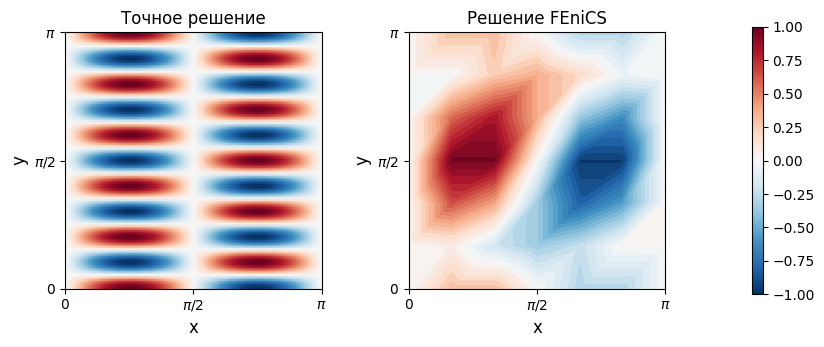

Шаг h =  0.25


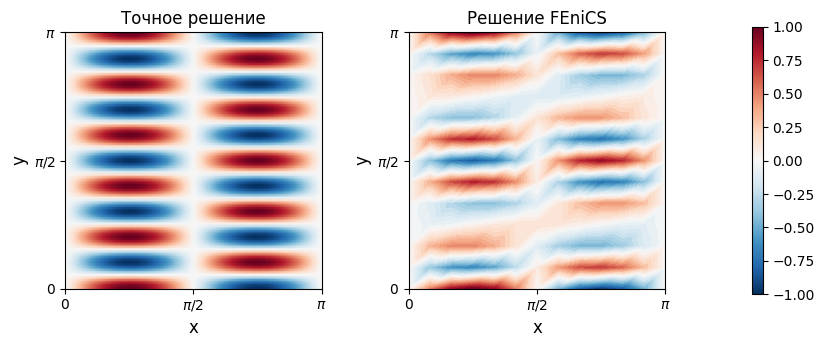

Шаг h =  0.125


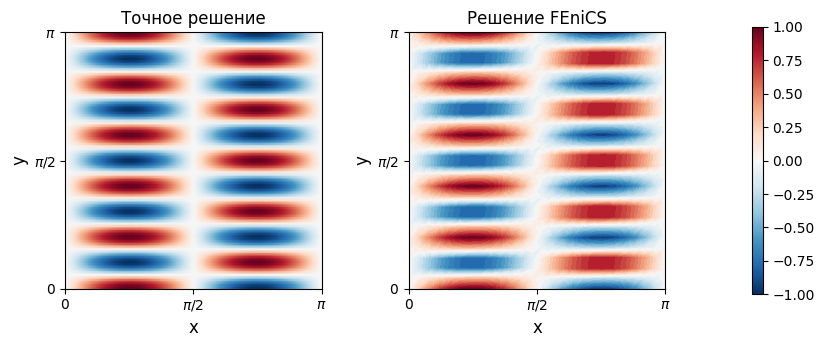

Шаг h =  0.05


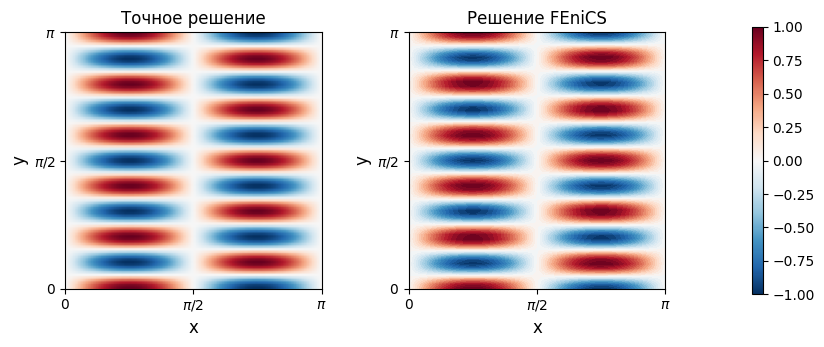

In [189]:
k = 2
l = 10
i = 2
h=[1, 0.5, 0.25, 0.125, 0.05]
for h_values in h:
  #mesh, u_solution = solve_pde(f_exp[i], u_d[i], h)
  print(f"Шаг h =  {h_values}")
  visualize_solution(k,l,h_values,i)

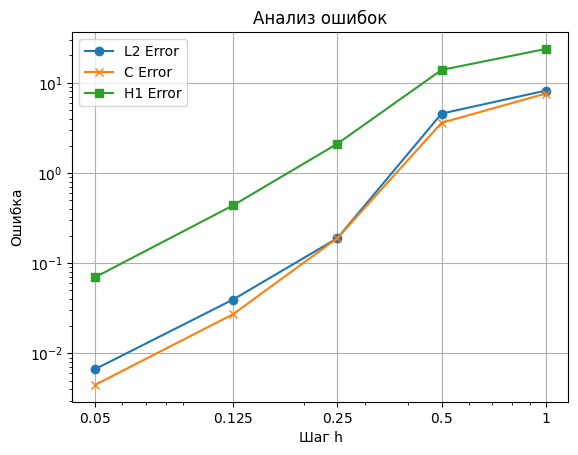

In [175]:
analyze_errors(2)

Прямоугольная сетка

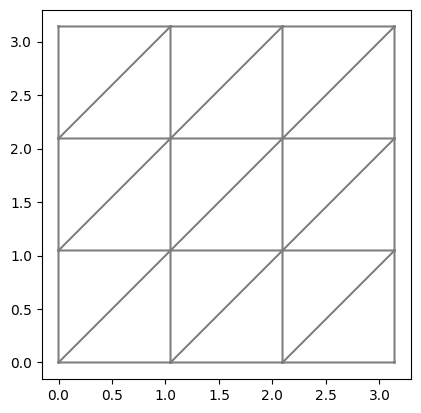

In [ ]:
def create_mesh(h):

    p0 = Point(0.0, 0.0)
    p1 = Point(np.pi, np.pi)
    return RectangleMesh(p0, p1, int(np.pi/h), int(np.pi/h))

h = 1
mesh = create_mesh(h)

plot(mesh)
plt.show()